<a href="https://colab.research.google.com/github/vstrah00/CUDA-transformations--GPU-vs-CPU-/blob/main/gpu_sobel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For both CPU and GPU notebooks
!pip install opencv-python
!pip install opencv-python-headless

In [ ]:
# For the GPU notebook
!pip install pycuda

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*in out-of-thread context.*")

In [5]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import time

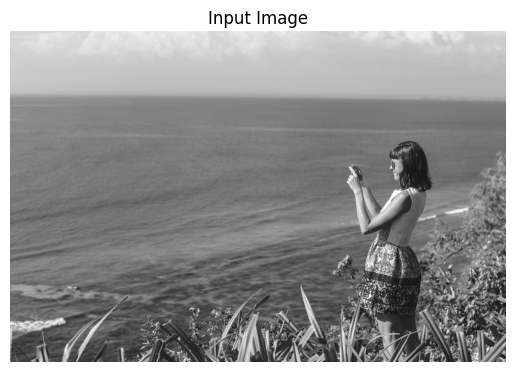

In [13]:
# Function to load and preprocess the image
def load_image(filename):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Error: Could not load image.")
    return image

# Load the image
filename = 'taking-pic.jpg'  # Update with your image path
image = load_image(filename)

# Display the input image
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.show()

In [8]:
# Define the CUDA kernel for Sobel filtering
sobel_kernel = """
__global__ void sobel_filter(const unsigned char* input, unsigned char* output, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= width || y >= height) return;

    int sobel_x[3][3] = {
        {-1, 0, 1},
        {-2, 0, 2},
        {-1, 0, 1}
    };

    int sobel_y[3][3] = {
        {-1, -2, -1},
        {0, 0, 0},
        {1, 2, 1}
    };

    float gx = 0.0f, gy = 0.0f;
    for (int i = -1; i <= 1; ++i) {
        for (int j = -1; j <= 1; ++j) {
            int ix = min(max(x + i, 0), width - 1);
            int iy = min(max(y + j, 0), height - 1);
            gx += input[iy * width + ix] * sobel_x[i + 1][j + 1];
            gy += input[iy * width + ix] * sobel_y[i + 1][j + 1];
        }
    }

    int idx = y * width + x;
    float magnitude = sqrt(gx * gx + gy * gy);
    output[idx] = min(max(int(magnitude), 0), 255);
}
"""

In [14]:
# Compile the CUDA kernel
mod = SourceModule(sobel_kernel)
sobel_filter = mod.get_function("sobel_filter")

def sobel_filter_gpu(image):
    height, width = image.shape
    image_size = width * height
    output_image = np.zeros_like(image)

    d_input = cuda.mem_alloc(image.nbytes)
    d_output = cuda.mem_alloc(output_image.nbytes)

    cuda.memcpy_htod(d_input, image)

    block_size = (16, 16, 1)
    grid_size = (int(np.ceil(width / block_size[0])), int(np.ceil(height / block_size[1])), 1)

    sobel_filter(d_input, d_output, np.int32(width), np.int32(height), block=block_size, grid=grid_size)
    cuda.memcpy_dtoh(output_image, d_output)

    d_input.free()
    d_output.free()

    return output_image

GPU Time: 0.018642 seconds


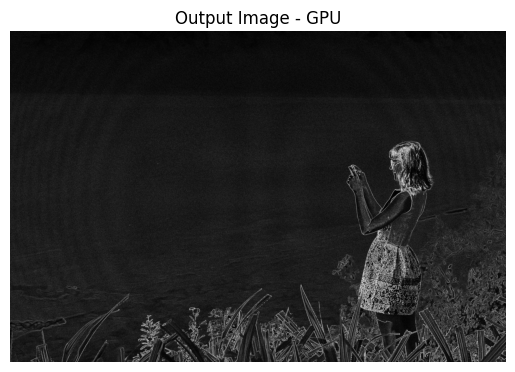

In [16]:
# Measure GPU performance
start_time = time.time()
output_gpu = sobel_filter_gpu(image)
end_time = time.time()
gpu_time = end_time - start_time
print(f"GPU Time: {gpu_time:.6f} seconds")

# Display the result
plt.imshow(output_gpu, cmap='gray')
plt.title('Output Image - GPU')
plt.axis('off')
plt.show()